1. rgb값 대신 band_1, band_2 2개의 채널로 이루어진 데이터
2. 3채널을 가지는 2가지의 데이터로 가공
  - band: band_1, band_2와 두개를 평균낸 band_3에 gray scaling, denoising, smoothing 적용
  - image: r,g,b를 임의로 정의(band + abs(band.min())) / np.max((band + abs(band.min())))하고 denoising,smoothing 적용
3. band와 image 데이터를 같은 모델로 각각 학습 ( 맨 아래의 plot_model(model) 참고)
4. 두 모델에서 학습된 아웃풋을 concatenate한 후 추가적으로 학습 과정 거쳐서 단일아웃풋 출력 (맨 아래의 plot_model(common_model) 참고)

In [1]:
import os
path = '/Users/dayoungcho/Desktop/kaggle/statoil-iceberg-classifier-challenge'
os.chdir(path)

In [2]:
import numpy as np
import tensorflow as tf
np.random.seed(98643)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # hide TF warnings about allocation

# image clearing dependencies
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma, denoise_tv_bregman, denoise_nl_means)
from skimage.filters import gaussian
from skimage.color import rgb2gray

# data reading and visualization
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

# training
from keras import layers,models,optimizers
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, Lambda, Concatenate
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam

/Users/dayoungcho/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### preprocessing

In [3]:
# 데이터를 이미지 형태로 변환

def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75,75)
        band_2 = np.array(row['band_2']).reshape(75,75)
        band_3 = band_1 / band_2

        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))

        rgb = np.dstack((r,g,b))
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)

def denoise(X, weight, multichannel):
    return np.asarray([denoise_tv_chambolle(item, weight=weight, multichannel=multichannel) for item in X])

def smooth(X, sigma):
    return np.asarray([gaussian(item, sigma=sigma) for item in X])

def grayscale(X):
    return np.asarray([rgb2gray(item) for item in X])

In [4]:
train = pd.read_json('train.json')

# 결측치처리
train.inc_angle = train.inc_angle.replace('na', 0) 
train.inc_angle = train.inc_angle.astype(float)

# train flags to train model more efficiently
train_all = True
train_b = True or train_all
train_img = True or train_all
train_total = True or train_all
predict_submission = True and train_all

clean_all = False
clean_b = False or clean_all
clean_img = False or clean_all

load_all = False
load_b = False or load_all
load_img = False or load_all

In [5]:
def create_dataset(frame, labeled, smooth_rgb = 0.2, smooth_gray = 0.5, weight_rgb = 0.05, weight_gray = 0.05):
    band_1, band_2, images = frame['band_1'].values, frame['band_2'].values, color_composite(frame)

    to_arr = lambda x: np.asarray([np.asarray(item) for item in x])
    band_1 = to_arr(band_1)
    band_2 = to_arr(band_2)
    band_3 = (band_1 + band_2) / 2

    gray_reshape = lambda x: np.asarray([item.reshape(75,75) for item in x])
    band_1 = gray_reshape(band_1)
    band_2 = gray_reshape(band_2)
    band_3 = gray_reshape(band_3)

    print('Denoising and reshaping')

    if train_b and clean_b:  # smooth & denoise
        band_1 = smooth(denoise(band_1, weight_gray, False), smooth_gray)
        print('Gray 1 done')
        band_2 = smooth(denoise(band_2, weight_gray, False), smooth_gray)
        print('Gray 2 done')
        band_3 = smooth(denoise(band_3, weight_gray, False), smooth_gray)
        print('Gray 3 done')

    if train_img and clean_img:   # smooth & denoise
        images = smooth(denoise(images, weight_rgb, True), smooth_rgb)

    print('RGB done')

    tf_reshape = lambda x: np.asarray([item.reshape(75,75,1) for item in x])
    band_1 = tf_reshape(band_1)
    band_2 = tf_reshape(band_2)
    band_3 = tf_reshape(band_3)

    band = np.concatenate([band_1, band_2, band_3], axis=3)

    if labeled:
        y = np.array(frame['is_iceberg'])
    else:
        y = None
    
    return y, band, images

In [6]:
y_train, X_b, X_images = create_dataset(train, True)

Denoising and reshaping
RGB done


In [9]:
X_b.shape

(1604, 75, 75, 3)

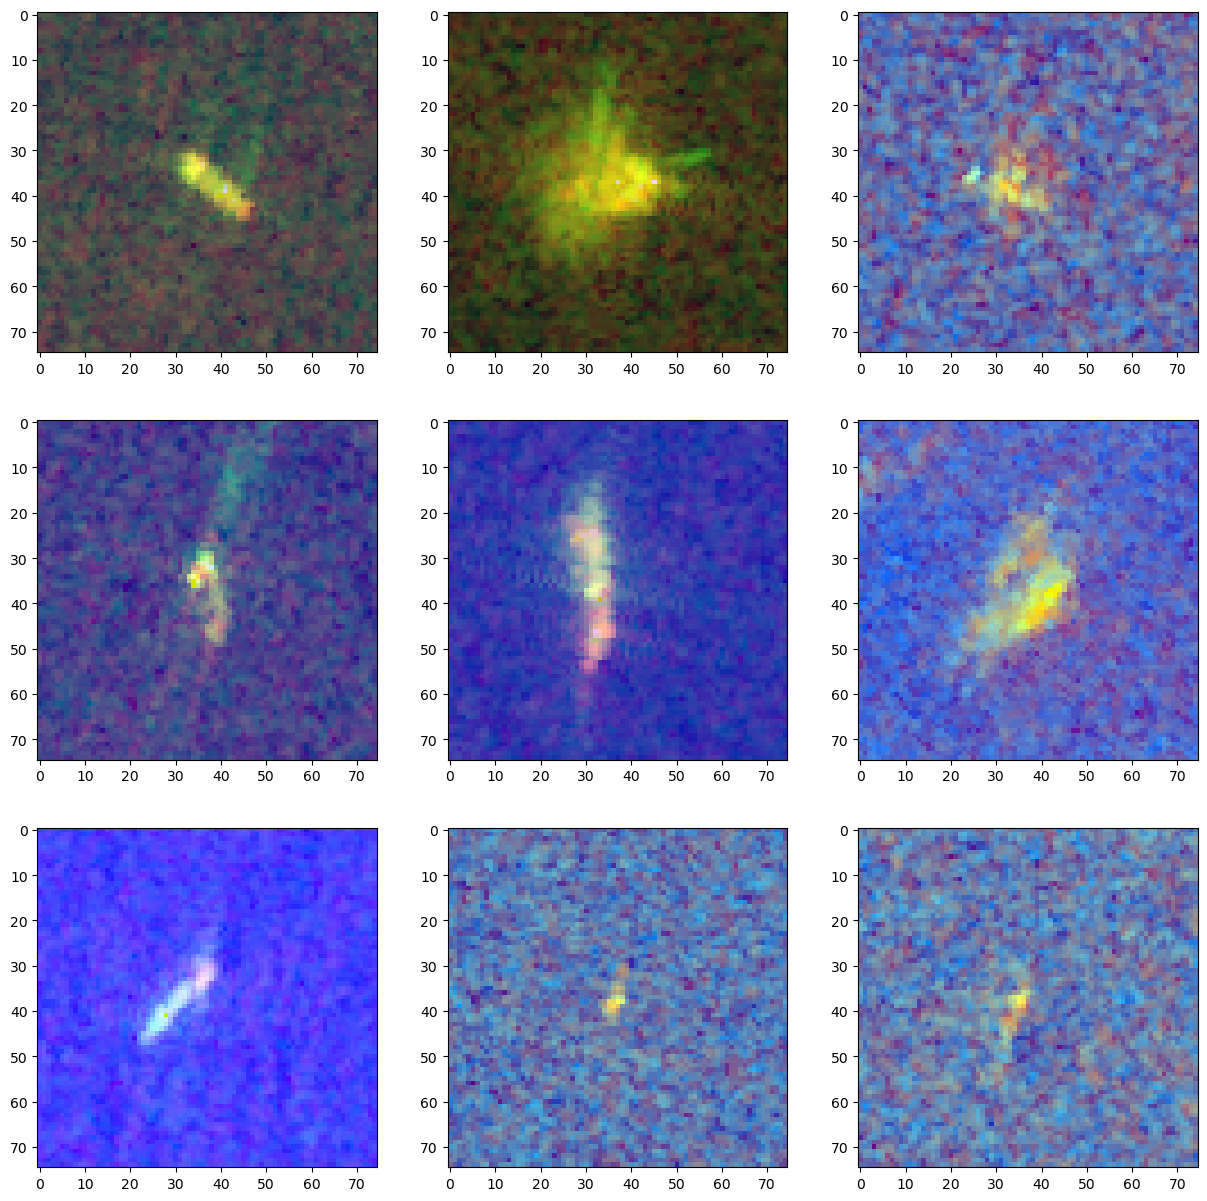

In [16]:
# preprocess 이전 이미지

fig = plt.figure(200,figsize=(15,15))
random_indices = np.random.choice(range(len(X_images)), 9 , False)
subset = X_images[random_indices]
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

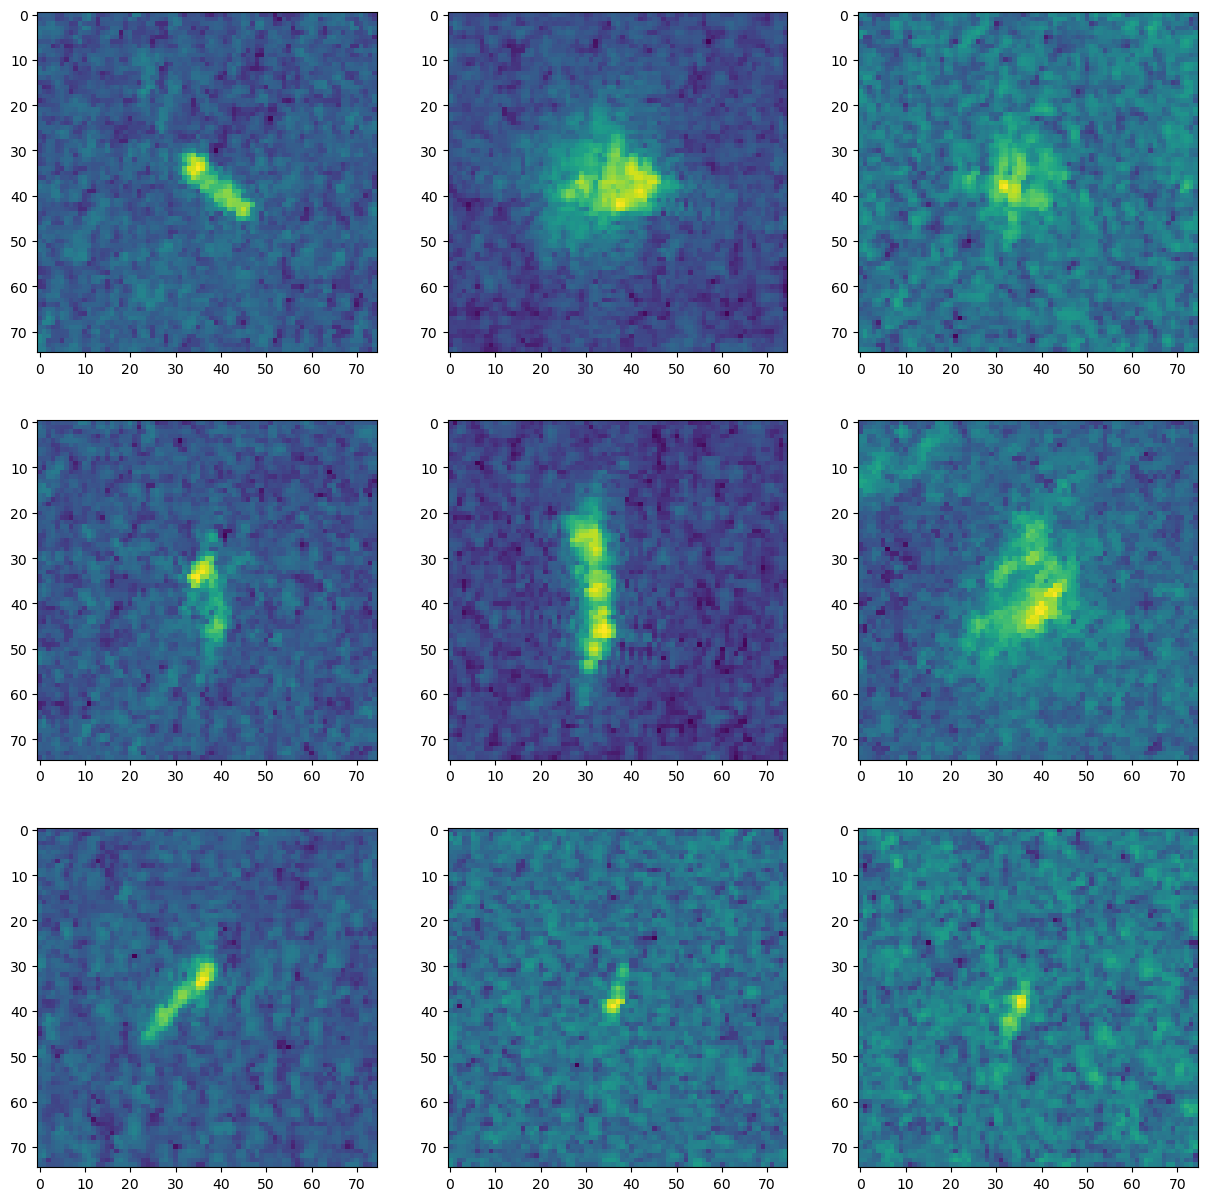

In [17]:
# band1 시각화

fig = plt.figure(202, figsize=(15,15))
band_1_x = train['band_1'].values
subset = np.asarray(band_1_x)[random_indices]
subset = np.asarray([np.asarray(item).reshape(75, 75) for item in subset])
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

/var/folders/fd/1n9xc_8d2d51bf04p61cdylw0000gn/T/ipykernel_79177/4045138523.py:19: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return np.asarray([denoise_tv_chambolle(item, weight=weight, multichannel=multichannel) for item in X])


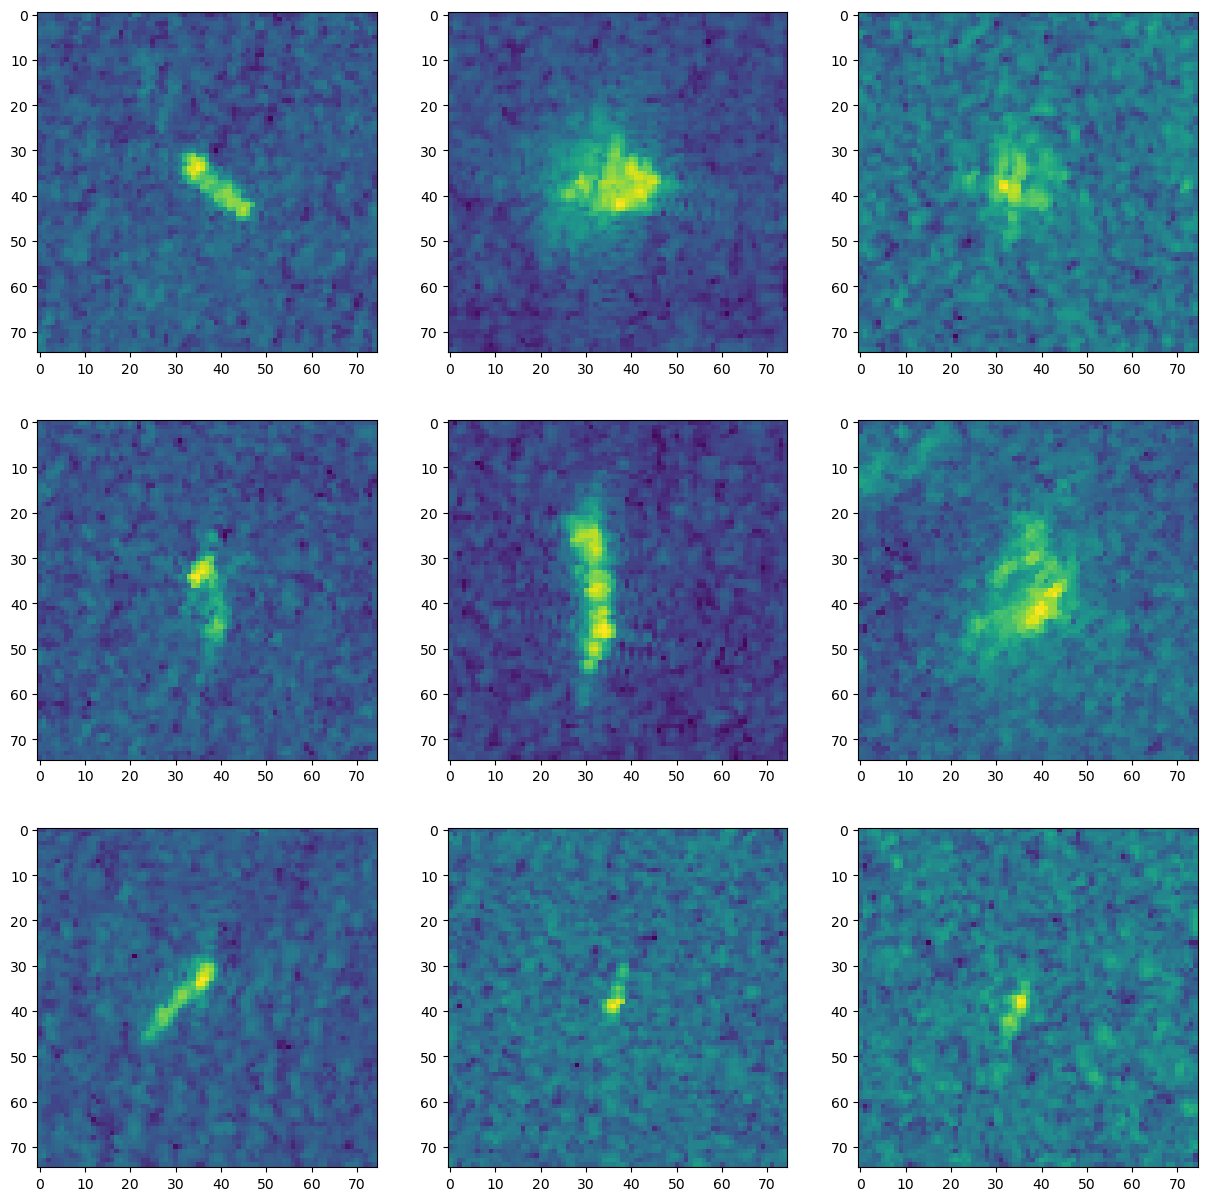

In [19]:
# denoise 이후의 band1 시각화

fig = plt.figure(202, figsize=(15, 15))
subset = np.asarray(band_1_x)[random_indices]
subset = denoise(np.asarray([np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

/var/folders/fd/1n9xc_8d2d51bf04p61cdylw0000gn/T/ipykernel_79177/4045138523.py:19: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return np.asarray([denoise_tv_chambolle(item, weight=weight, multichannel=multichannel) for item in X])


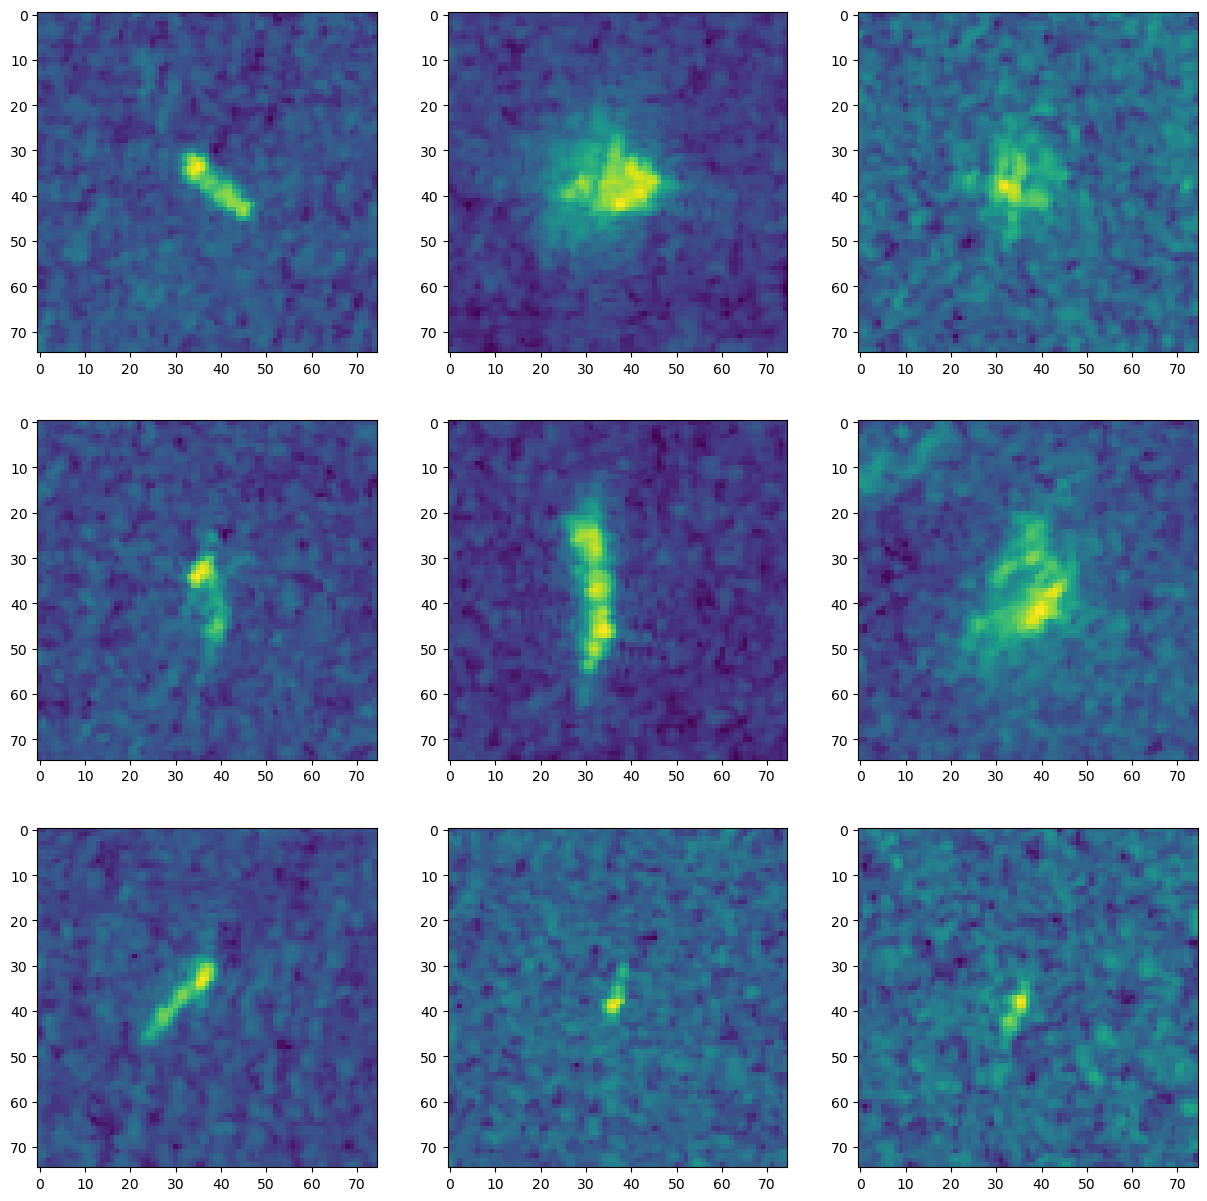

In [20]:
# smooth&denoise 이후의 band1 시각화

fig = plt.figure(202, figsize=(15, 15))
subset = np.asarray(band_1_x)[random_indices]
subset = smooth(denoise(np.asarray(
    [np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False), 0.5)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

In [77]:
def get_model_notebook(lr, decay, channels, relu_type='relu'):
    input_1 = Input(shape=(75, 75, channels))
    fcnn = Conv2D(32, kernel_size=(3, 3), activation=relu_type)(
        BatchNormalization()(input_1))
    fcnn = MaxPooling2D((3, 3))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(64, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = BatchNormalization()(fcnn)
    fcnn = Flatten()(fcnn)
    local_input = input_1
    partial_model = Model(input_1, fcnn)
    dense = Dropout(0.2)(fcnn)
    dense = Dense(256, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(128, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(64, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    output = Dense(1, activation="sigmoid")(dense)
    model = Model(local_input, output)
    optimizer = Adam(lr=lr, decay=decay)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model, partial_model

In [79]:
def combined_model(m_b, m_img, lr, decay):
    input_b = Input(shape=(75, 75, 3))
    input_img = Input(shape=(75, 75, 3))

    # I've never tested non-trainable source models tho
    #for layer in m_b.layers:
    #    layer.trainable = False
    #for layer in m_img.layers:
    #    layer.trainable = False

    m1 = m_b(input_b)
    m2 = m_img(input_img)

    # So, combine models and train perceptron based on that
    # The iteresting idea is to use XGB for this task, but i actually hate this method
    common = Concatenate()([m1, m2])
    common = BatchNormalization()(common)
    common = Dropout(0.3)(common)
    common = Dense(1024, activation='relu')(common)
    common = Dropout(0.3)(common)
    common = Dense(512, activation='relu')(common)
    common = Dropout(0.3)(common)
    output = Dense(1, activation="sigmoid")(common)
    model = Model([input_b, input_img], output)
    optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [56]:
def gen_flow_multi_inputs(I1, I2, y, batch_size):
    gen1 = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.,
                             height_shift_range=0.,
                             channel_shift_range=0,
                             zoom_range=0.2,
                             rotation_range=10)
    gen2 = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.,
                             height_shift_range=0.,
                             channel_shift_range=0,
                             zoom_range=0.2,
                             rotation_range=10)
    genI1 = gen1.flow(I1, y, batch_size=batch_size, seed=57, shuffle=False)
    genI2 = gen2.flow(I1, I2, batch_size=batch_size, seed=57, shuffle=False)
    while True:
        I1i = genI1.next()
        I2i = genI2.next()
        #print I1i[0].shape
        np.testing.assert_array_equal(I2i[0], I1i[0])
        yield [I1i[0], I2i[1]], I1i[1]

In [57]:
def train_model(model, batch_size, epochs, checkpoint_name, X_train, y_train, val_data, verbose=2):
    callbacks = [ModelCheckpoint(checkpoint_name, save_best_only=True, monitor='val_loss')]
    datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.,
                                   height_shift_range=0.,
                                   channel_shift_range=0,
                                   zoom_range=0.2,
                                   rotation_range=10)
    x_test, y_test = val_data
    try:
        model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs,
                                    steps_per_epoch=len(X_train) / batch_size,
                                    validation_data=(x_test, y_test), verbose=1,
                                    callbacks=callbacks)
    except KeyboardInterrupt:
        if verbose > 0:
            print('Interrupted')
    if verbose > 0:
        print('Loading model')
    model.load_weights(filepath=checkpoint_name)
    return model

In [58]:
#Train a particular model
def gen_model_weights(lr, decay, channels, relu, batch_size, epochs, path_name, data, verbose=2):
    X_train, y_train, X_test, y_test, X_val, y_val = data
    model, partial_model = get_model_notebook(lr, decay, channels, relu)
    model = train_model(model, batch_size, epochs, path_name,
                           X_train, y_train, (X_test, y_test), verbose=verbose)

    if verbose > 0:
        loss_val, acc_val = model.evaluate(X_val, y_val,
                               verbose=0, batch_size=batch_size)

        loss_train, acc_train = model.evaluate(X_test, y_test,
                                       verbose=0, batch_size=batch_size)
        print('Val/Train Loss:', str(loss_val) + '/' + str(loss_train), \
            'Val/Train Acc:', str(acc_val) + '/' + str(acc_train))
    return model, partial_model

In [59]:
# Train all 3 models
def train_models(dataset, lr, batch_size, max_epoch, verbose=2, return_model=False):
    y_train, X_b, X_images = dataset
    y_train_full, y_val,\
    X_b_full, X_b_val,\
    X_images_full, X_images_val = train_test_split(y_train, X_b, X_images, random_state=687, train_size=0.9)

    y_train, y_test, \
    X_b_train, X_b_test, \
    X_images_train, X_images_test = train_test_split(y_train_full, X_b_full, X_images_full, random_state=576, train_size=0.85)

    if train_b:
        if verbose > 0:
            print('Training bandwidth network')
        data_b1 = (X_b_train, y_train, X_b_test, y_test, X_b_val, y_val)
        model_b, model_b_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_b',
                                                 data=data_b1, verbose=verbose)

    if train_img:
        if verbose > 0:
            print('Training image network')
        data_images = (X_images_train, y_train, X_images_test, y_test, X_images_val, y_val)
        model_images, model_images_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_img',
                                                       data_images, verbose=verbose)
    if train_total:
        common_model = combined_model(model_b_cut, model_images_cut, lr/2, 1e-7)
        common_x_train = [X_b_full, X_images_full]
        common_y_train = y_train_full
        common_x_val = [X_b_val, X_images_val]
        common_y_val = y_val
        if verbose > 0:
            print('Training common network')
        callbacks = [ModelCheckpoint('common', save_best_only=True, monitor='val_loss')]
        try:
            common_model.fit_generator(gen_flow_multi_inputs(X_b_full, X_images_full, y_train_full, batch_size),
                                         epochs=30,
                                  steps_per_epoch=len(X_b_full) / batch_size,
                                  validation_data=(common_x_val, common_y_val), verbose=1,
                                  callbacks=callbacks)

        except KeyboardInterrupt:
            pass
        common_model.load_weights(filepath='common')
        loss_val, acc_val = common_model.evaluate(common_x_val, common_y_val,
                                           verbose=0, batch_size=batch_size)
        loss_train, acc_train = common_model.evaluate(common_x_train, common_y_train,
                                                  verbose=0, batch_size=batch_size)
        if verbose > 0:
            print('Loss:', loss_val, 'Acc:', acc_val)
    if return_model:
        return common_model
    else:
        return (loss_train, acc_train), (loss_val, acc_val)

In [84]:
# Best parameters i got are
# epochs : 250
# learning rate : 8e-5
# batch size : 32
common_model = train_models((y_train, X_b, X_images), 8e-5, 32, 250, 1, return_model=True)

Training bandwidth network


/Users/dayoungcho/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/var/folders/fd/1n9xc_8d2d51bf04p61cdylw0000gn/T/ipykernel_79177/2685180152.py:12: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs,


Epoch 1/250
39/38 [==============================] - ETA: 0s - batch: 19.0000 - size: 31.4359 - loss: 0.7804 - accuracy: 0.4967

/Users/dayoungcho/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: model_b/assets


INFO:tensorflow:Assets written to: model_b/assets


38/38 [==============================] - 19s 404ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.7804 - accuracy: 0.4967 - val_loss: 0.6928 - val_accuracy: 0.5253
Epoch 2/250
39/38 [==============================] - ETA: 0s - batch: 19.0000 - size: 31.4359 - loss: 0.6860 - accuracy: 0.5473

INFO:tensorflow:Assets written to: model_b/assets


INFO:tensorflow:Assets written to: model_b/assets


38/38 [==============================] - 7s 182ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.6860 - accuracy: 0.5473 - val_loss: 0.6911 - val_accuracy: 0.5253
Epoch 3/250
39/38 [==============================] - ETA: 0s - batch: 19.0000 - size: 31.4359 - loss: 0.6518 - accuracy: 0.5881

INFO:tensorflow:Assets written to: model_b/assets


INFO:tensorflow:Assets written to: model_b/assets


38/38 [==============================] - 7s 175ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.6517 - accuracy: 0.5881 - val_loss: 0.6753 - val_accuracy: 0.5300
Epoch 4/250
39/38 [==============================] - ETA: 0s - batch: 19.0000 - size: 31.4359 - loss: 0.6483 - accuracy: 0.5987

INFO:tensorflow:Assets written to: model_b/assets


INFO:tensorflow:Assets written to: model_b/assets


38/38 [==============================] - 6s 149ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.6483 - accuracy: 0.5987 - val_loss: 0.6731 - val_accuracy: 0.6544
Epoch 5/250
39/38 [==============================] - ETA: 0s - batch: 19.0000 - size: 31.4359 - loss: 0.6334 - accuracy: 0.6020

INFO:tensorflow:Assets written to: model_b/assets


INFO:tensorflow:Assets written to: model_b/assets


38/38 [==============================] - 6s 161ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.6334 - accuracy: 0.6020 - val_loss: 0.6711 - val_accuracy: 0.6267
Epoch 6/250
39/38 [==============================] - ETA: 0s - batch: 19.0000 - size: 31.4359 - loss: 0.6504 - accuracy: 0.5873

INFO:tensorflow:Assets written to: model_b/assets


INFO:tensorflow:Assets written to: model_b/assets


38/38 [==============================] - 9s 237ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.6503 - accuracy: 0.5873 - val_loss: 0.6707 - val_accuracy: 0.6037
Epoch 7/250
39/38 [==============================] - ETA: 0s - batch: 19.0000 - size: 31.4359 - loss: 0.6307 - accuracy: 0.6199

INFO:tensorflow:Assets written to: model_b/assets


INFO:tensorflow:Assets written to: model_b/assets


38/38 [==============================] - 9s 232ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.6307 - accuracy: 0.6199 - val_loss: 0.6645 - val_accuracy: 0.6175
Epoch 8/250
38/38 [==============================] - 3s 79ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.6258 - accuracy: 0.6150 - val_loss: 0.6646 - val_accuracy: 0.5991
Epoch 9/250
38/38 [==============================] - 3s 80ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.6171 - accuracy: 0.6158 - val_loss: 0.6752 - val_accuracy: 0.5853
Epoch 10/250
38/38 [==============================] - 3s 75ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.6188 - accuracy: 0.6378 - val_loss: 0.6872 - val_accuracy: 0.5392
Epoch 11/250
38/38 [==============================] - 3s 72ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.6201 - accuracy: 0.6427 - val_loss: 0.6986 - val_accuracy: 0.4885
Epoch 12/250
38/38 [==============================] - 3s 71ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.6057 - accuracy: 0.6476 

INFO:tensorflow:Assets written to: model_b/assets


INFO:tensorflow:Assets written to: model_b/assets


38/38 [==============================] - 9s 235ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.5114 - accuracy: 0.7480 - val_loss: 0.6273 - val_accuracy: 0.5853
Epoch 30/250
39/38 [==============================] - ETA: 0s - batch: 19.0000 - size: 31.4359 - loss: 0.4843 - accuracy: 0.7504

INFO:tensorflow:Assets written to: model_b/assets


INFO:tensorflow:Assets written to: model_b/assets


38/38 [==============================] - 7s 172ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.4842 - accuracy: 0.7504 - val_loss: 0.6241 - val_accuracy: 0.5991
Epoch 31/250
38/38 [==============================] - 3s 90ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.4880 - accuracy: 0.7480 - val_loss: 0.6431 - val_accuracy: 0.5760
Epoch 32/250
39/38 [==============================] - ETA: 0s - batch: 19.0000 - size: 31.4359 - loss: 0.4817 - accuracy: 0.7520

INFO:tensorflow:Assets written to: model_b/assets


INFO:tensorflow:Assets written to: model_b/assets


38/38 [==============================] - 7s 178ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.4817 - accuracy: 0.7520 - val_loss: 0.6175 - val_accuracy: 0.5945
Epoch 33/250
38/38 [==============================] - 3s 77ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.4823 - accuracy: 0.7594 - val_loss: 0.6229 - val_accuracy: 0.5991
Epoch 34/250
38/38 [==============================] - 3s 82ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.4747 - accuracy: 0.7675 - val_loss: 0.6506 - val_accuracy: 0.5853
Epoch 35/250
39/38 [==============================] - ETA: 0s - batch: 19.0000 - size: 31.4359 - loss: 0.4682 - accuracy: 0.7651

INFO:tensorflow:Assets written to: model_b/assets


INFO:tensorflow:Assets written to: model_b/assets


38/38 [==============================] - 6s 172ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.4683 - accuracy: 0.7651 - val_loss: 0.5876 - val_accuracy: 0.6452
Epoch 36/250
38/38 [==============================] - 3s 86ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.4626 - accuracy: 0.7708 - val_loss: 0.6548 - val_accuracy: 0.5991
Epoch 37/250
38/38 [==============================] - 3s 89ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.4612 - accuracy: 0.7806 - val_loss: 0.6149 - val_accuracy: 0.6267
Epoch 38/250
38/38 [==============================] - 3s 73ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.4742 - accuracy: 0.7602 - val_loss: 0.6756 - val_accuracy: 0.5991
Epoch 39/250
38/38 [==============================] - 3s 81ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.4582 - accuracy: 0.7790 - val_loss: 0.7125 - val_accuracy: 0.5484
Epoch 40/250
38/38 [==============================] - 3s 84ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.4324 - accuracy: 0.785

INFO:tensorflow:Assets written to: model_b/assets


INFO:tensorflow:Assets written to: model_b/assets


38/38 [==============================] - 6s 155ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.4543 - accuracy: 0.7692 - val_loss: 0.5801 - val_accuracy: 0.6866
Epoch 43/250
38/38 [==============================] - 3s 80ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.4247 - accuracy: 0.7830 - val_loss: 0.6384 - val_accuracy: 0.6498
Epoch 44/250
38/38 [==============================] - 3s 88ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.4269 - accuracy: 0.7887 - val_loss: 0.6584 - val_accuracy: 0.6544
Epoch 45/250
39/38 [==============================] - ETA: 0s - batch: 19.0000 - size: 31.4359 - loss: 0.4165 - accuracy: 0.7879

INFO:tensorflow:Assets written to: model_b/assets


INFO:tensorflow:Assets written to: model_b/assets


38/38 [==============================] - 7s 184ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.4166 - accuracy: 0.7879 - val_loss: 0.5684 - val_accuracy: 0.7143
Epoch 46/250
38/38 [==============================] - 4s 92ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.4048 - accuracy: 0.7961 - val_loss: 0.5690 - val_accuracy: 0.7235
Epoch 47/250
38/38 [==============================] - 3s 87ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.4165 - accuracy: 0.7969 - val_loss: 0.7257 - val_accuracy: 0.6313
Epoch 48/250
38/38 [==============================] - 3s 88ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.4003 - accuracy: 0.8148 - val_loss: 0.7182 - val_accuracy: 0.6728
Epoch 49/250
38/38 [==============================] - 3s 88ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.4197 - accuracy: 0.7871 - val_loss: 0.6288 - val_accuracy: 0.7097
Epoch 50/250
38/38 [==============================] - 3s 89ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.3867 - accuracy: 0.808

INFO:tensorflow:Assets written to: model_b/assets


INFO:tensorflow:Assets written to: model_b/assets


38/38 [==============================] - 7s 177ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.4131 - accuracy: 0.8189 - val_loss: 0.5644 - val_accuracy: 0.7512
Epoch 53/250
38/38 [==============================] - 3s 79ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.4185 - accuracy: 0.7822 - val_loss: 0.6371 - val_accuracy: 0.7143
Epoch 54/250
38/38 [==============================] - 3s 72ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.3874 - accuracy: 0.8059 - val_loss: 0.6399 - val_accuracy: 0.7097
Epoch 55/250
38/38 [==============================] - 3s 73ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.3806 - accuracy: 0.8254 - val_loss: 0.6703 - val_accuracy: 0.7097
Epoch 56/250
38/38 [==============================] - 3s 73ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.3879 - accuracy: 0.8230 - val_loss: 0.6633 - val_accuracy: 0.7051
Epoch 57/250
38/38 [==============================] - 3s 73ms/step - batch: 19.0000 - size: 31.4359 - loss: 0.3971 - accuracy: 0.804

/Users/dayoungcho/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/var/folders/fd/1n9xc_8d2d51bf04p61cdylw0000gn/T/ipykernel_79177/2685180152.py:12: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs,


Epoch 1/250
39/38 [==============================] - ETA: 0s - batch: 19.0000 - size: 31.4359 - loss: 0.7093 - accuracy: 0.5514

/Users/dayoungcho/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: model_img/assets


INFO:tensorflow:Assets written to: model_img/assets


In [71]:
if predict_submission:
    print('Reading test dataset')
    test = pd.read_json("test.json")
    y_fin, X_fin_b, X_fin_img = create_dataset(test, False)
    print('Predicting')
    prediction = common_model.predict([X_fin_b, X_fin_img], verbose=1, batch_size=32)
    print('Submitting')
    submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})

    submission.to_csv("submission_250epoch.csv", index=False)
    print('Done')

Reading test dataset
Denoising and reshaping
RGB done
Predicting


/Users/dayoungcho/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Submitting
Done


/Users/dayoungcho/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


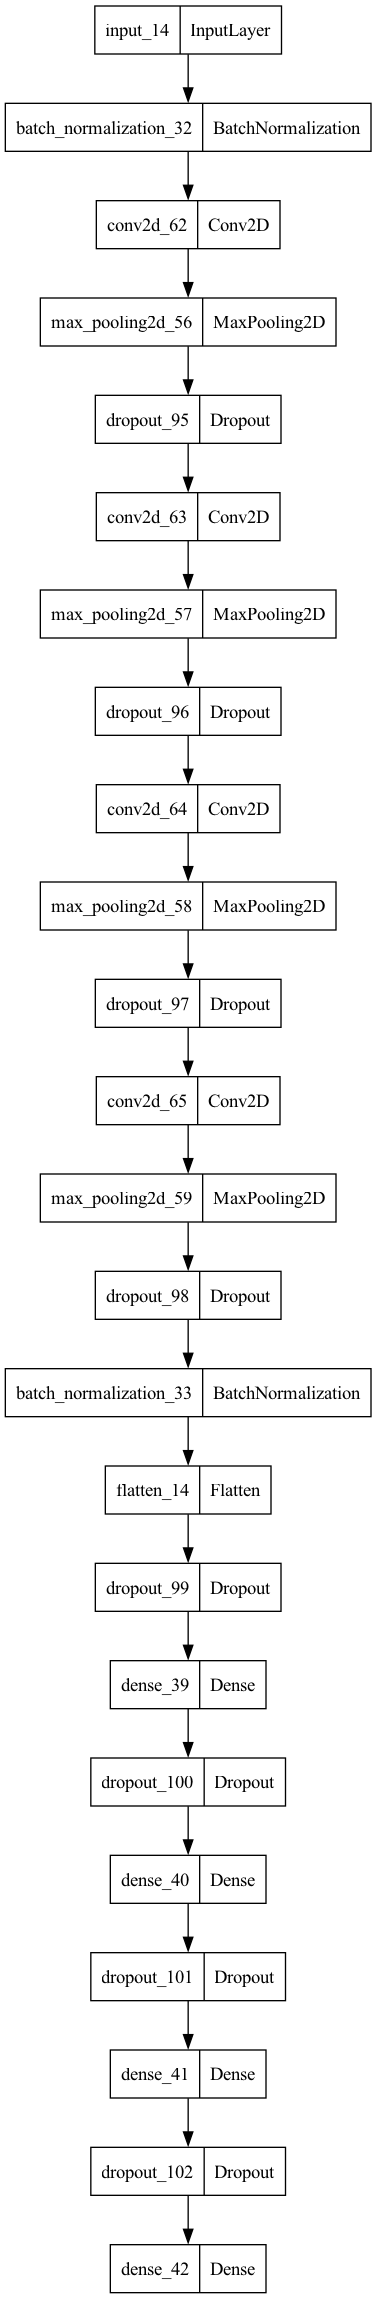

In [83]:
model, partial_model = get_model_notebook(lr = 7e-04, decay = 8e-3, channels=3, relu_type='relu')
plot_model(model)

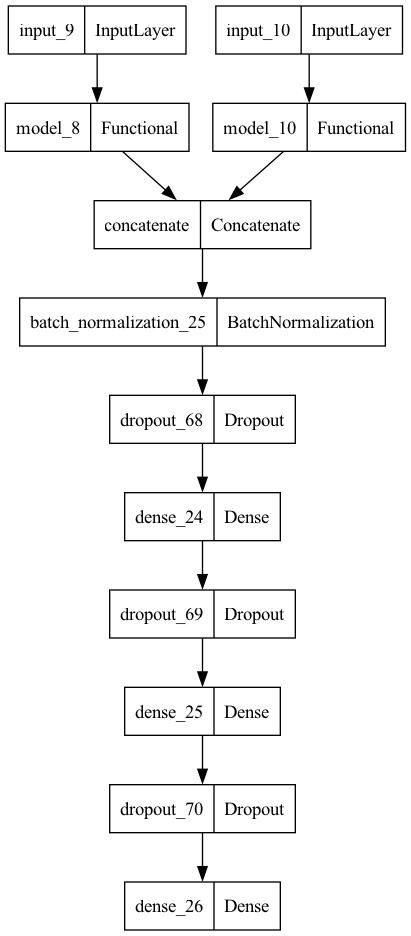

In [81]:
plot_model(common_model)